C:\Users\Zach\AppData\Local\Temp\ipykernel_28144\2354591257.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(features_present))


Ridge coefficient path PDF saved to: P2_Ridge_Coefficient_Path_LogConsumption_ShiftedX.pdf


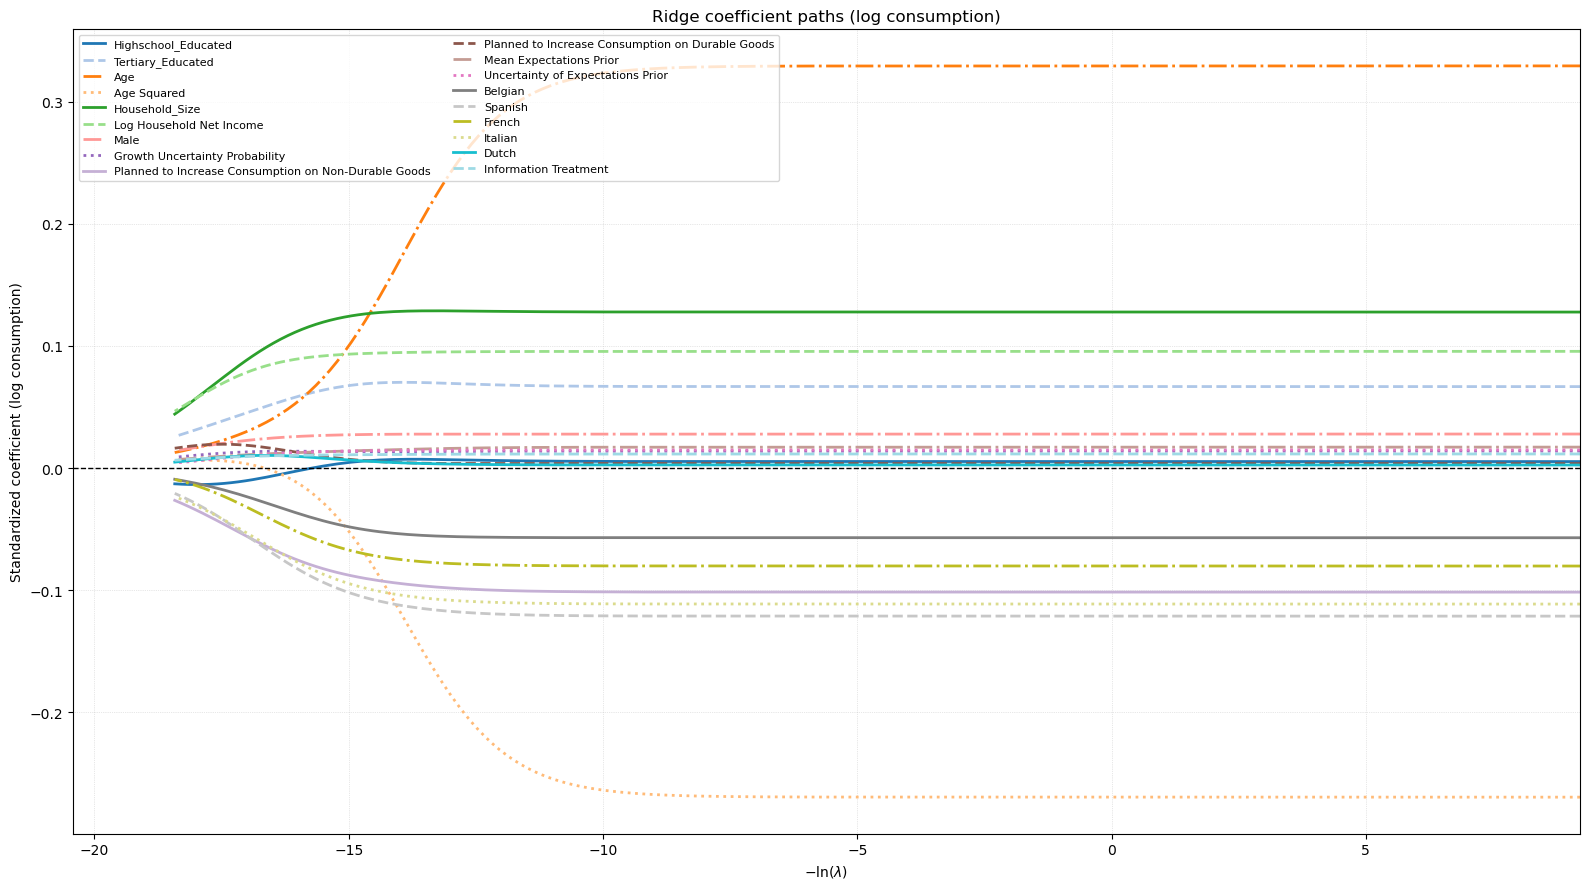

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ----------------- CONFIG -----------------
DATA_PATH = "CES_RF_SMT_clean.csv"
OUTCOME_VAR = "lc_w13"          # log(consumption)
WEIGHT_VAR = "wgt"
TREATMENT_VAR = "Second_Moment_Treatment"

FEATURES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Log_Household_Net_Income",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
    "Second_Moment_Treatment"
]

OUT_PDF = "P2_Ridge_Coefficient_Path_LogConsumption_ShiftedX.pdf"
# -----------------------------------------

# ----------------- LOAD DATA -----------------
df = pd.read_csv(DATA_PATH)

# Optional renaming for readability
rename_map = {
    "pr2010D": "Planned to Increase Consumption on Non-Durable Goods",
    "pr2110D": "Planned to Increase Consumption on Durable Goods",
    "age2": "Age Squared",
    "First_Moment_Expectation_Prior": "Mean Expectations Prior",
    "Second_Moment_Prior": "Uncertainty of Expectations Prior",
    "Log_Household_Net_Income": "Log Household Net Income",
    "Growth_Uncertainty_Probability": "Growth Uncertainty Probability",
    "Second_Moment_Treatment": "Information Treatment",
}
df = df.rename(columns=rename_map)
FEATURES = [rename_map.get(f, f) for f in FEATURES]
TREATMENT_VAR_RENAMED = rename_map.get(TREATMENT_VAR, TREATMENT_VAR)

# Keep only required columns and drop missing
cols_to_keep = [OUTCOME_VAR, TREATMENT_VAR_RENAMED] + FEATURES + ([WEIGHT_VAR] if WEIGHT_VAR in df.columns else [])
cols_to_keep = [c for c in cols_to_keep if c in df.columns]
df = df[cols_to_keep].dropna()

# Prepare X, y, w
features_present = [f for f in FEATURES if f in df.columns]
X = df[features_present].astype(float)
y = df[OUTCOME_VAR].astype(float)
w = df[WEIGHT_VAR].astype(float) if WEIGHT_VAR in df.columns else None

# ----------------- STANDARDIZE -----------------
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
scales = scaler.scale_

# ----------------- RIDGE PATH -----------------
# Extended λ range to visualize shrinkage clearly
alphas = np.logspace(-4, 8, 200)
coefs_scaled = np.zeros((len(alphas), X.shape[1]))

for i, a in enumerate(alphas):
    ridge = Ridge(alpha=a, fit_intercept=True)
    if w is not None:
        sw = w.values if isinstance(w, pd.Series) else w
        ridge.fit(X_scaled, y, sample_weight=sw)
    else:
        ridge.fit(X_scaled, y)
    coefs_scaled[i, :] = ridge.coef_

# ----------------- PLOT -----------------
x = -np.log(alphas)
plt.figure(figsize=(16, 9))

colors = cm.get_cmap('tab20', len(features_present))
linestyles = ['-', '--', '-.', ':']

for j, feat in enumerate(features_present):
    plt.plot(x, coefs_scaled[:, j],
             label=feat,
             color=colors(j),
             linestyle=linestyles[j % len(linestyles)],
             linewidth=2)

plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.xlabel(r"$-\ln(\lambda)$")
plt.ylabel("Standardized coefficient (log consumption)")
plt.title("Ridge coefficient paths (log consumption)")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
plt.legend(loc='best', fontsize=8, ncol=2)
plt.tight_layout()

# Shift x-axis further left to show strong shrinkage
plt.xlim(x.min()-2, x.max())

# save PDF and show inline
plt.savefig(OUT_PDF)

print(f"Ridge coefficient path PDF saved to: {OUT_PDF}")


C:\Users\Zach\AppData\Local\Temp\ipykernel_28144\1026234720.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(FEATURES))


LASSO coefficient path PDF saved to: P2_LASSO_Coefficient_Path_Colored.pdf


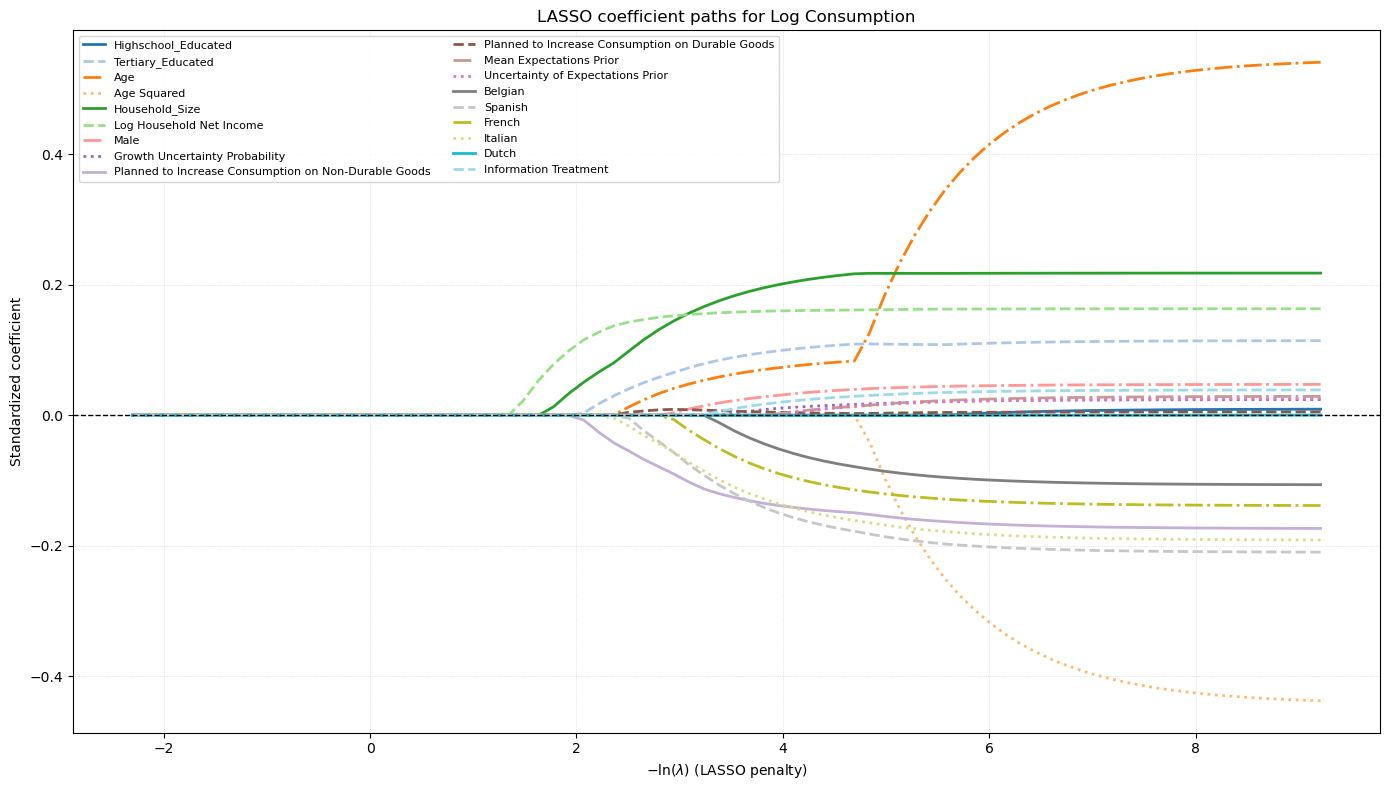

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.cm as cm

# ----------------- CONFIG -----------------
DATA_PATH = "CES_RF_SMT_clean.csv"
OUTCOME_VAR = "lc_w13"       # log(consumption)
WEIGHT_VAR = "wgt"

FEATURES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Log_Household_Net_Income",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
    "Second_Moment_Treatment",
]

OUT_PDF = "P2_LASSO_Coefficient_Path_Colored.pdf"
# -----------------------------------------

# 1) Load & clean data
df = pd.read_csv(DATA_PATH)

rename_map = {
    "pr2010D": "Planned to Increase Consumption on Non-Durable Goods",
    "pr2110D": "Planned to Increase Consumption on Durable Goods",
    "age2": "Age Squared",
    "First_Moment_Expectation_Prior": "Mean Expectations Prior",
    "Second_Moment_Prior": "Uncertainty of Expectations Prior",
    "Log_Household_Net_Income": "Log Household Net Income",
    "Growth_Uncertainty_Probability": "Growth Uncertainty Probability",
    "Second_Moment_Treatment": "Information Treatment",
}
df = df.rename(columns=rename_map)
FEATURES = [rename_map.get(f, f) for f in FEATURES]

cols_needed = [OUTCOME_VAR, WEIGHT_VAR] + FEATURES
df = df[cols_needed].dropna()

# 2) Prepare X, y, weights
y = df[OUTCOME_VAR].values.reshape(-1, 1)
weights = df[WEIGHT_VAR].values
X = df[FEATURES].astype(float).values

# standardize X and y
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y).ravel()

# 3) LASSO path
lambdas = np.logspace(-4, 1, 80)
coefs_lasso = []

for lam in lambdas:
    model = Lasso(alpha=lam, fit_intercept=False, max_iter=10000)
    model.fit(X_scaled, y_scaled, sample_weight=weights)
    coefs_lasso.append(model.coef_.ravel())

coefs_lasso = np.array(coefs_lasso)  # shape: (n_lambdas, n_features)

# 4) Plot coefficient paths with distinct colors & line styles
plt.figure(figsize=(14, 8))
x_vals = -np.log(lambdas)

# color map and line styles
colors = cm.get_cmap('tab20', len(FEATURES))
linestyles = ['-', '--', '-.', ':']

for j, feat in enumerate(FEATURES):
    plt.plot(x_vals, coefs_lasso[:, j],
             label=feat,
             color=colors(j),
             linestyle=linestyles[j % len(linestyles)],
             linewidth=2)

plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.xlabel(r"$-\ln(\lambda)$ (LASSO penalty)")
plt.ylabel("Standardized coefficient")
plt.title("LASSO coefficient paths for Log Consumption")
plt.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
plt.legend(fontsize=8, ncol=2, loc="best")
plt.tight_layout()

# save PDF and show plot inline
plt.savefig(OUT_PDF)

print(f"LASSO coefficient path PDF saved to: {OUT_PDF}")


Best lambda (weighted CV): 10000.0
Ridge coefficient path PDF saved to: P2_Ridge_Cross_Validation_Curve.pdf


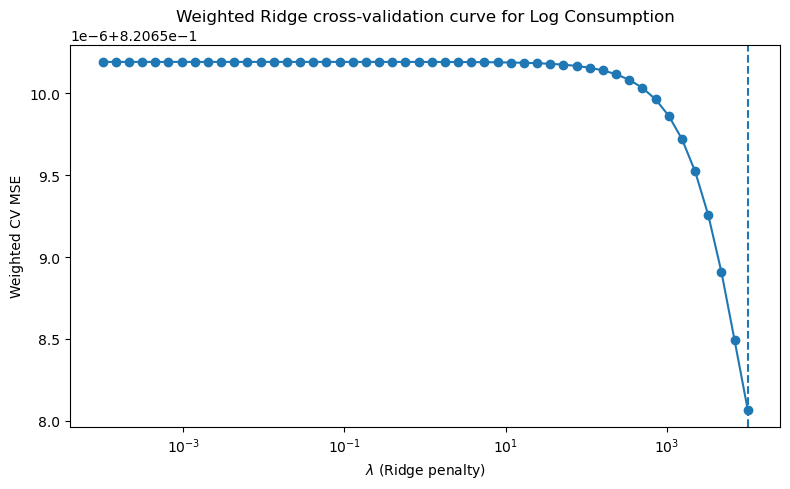

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

DATA_PATH   = "CES_RF_SMT_clean.csv"
OUTCOME_VAR = "lc_w13"
WEIGHT_VAR  = "wgt"

FEATURES = [
    "Highschool_Educated",
    "Tertiary_Educated",
    "Age",
    "age2",
    "Household_Size",
    "Log_Household_Net_Income",
    "Male",
    "Growth_Uncertainty_Probability",
    "pr2010D",
    "pr2110D",
    "First_Moment_Expectation_Prior",
    "Second_Moment_Prior",
    "Belgian", "Spanish", "French", "Italian", "Dutch",
]

# ---------- load & clean ----------
df = pd.read_csv(DATA_PATH)

rename_map = {
    # user-specified renames
    "pr2010D": "Planned to Increase Consumption on Non-Durable Goods",
    "pr2110D": "Planned to Increase Consumption on Durable Goods",
    "age2": "Age Squared",
    "First_Moment_Expectation_Prior": "Mean Expectations Prior",
    "Second_Moment_Prior": "Uncertainty of Expectations Prior",
    "Log_Household_Net_Income": "Log Household Net Income",
    "Growth_Uncertainty_Probability": "Growth Uncertainty Probability",
    # treatment rename (kept even if not in FEATURES)
    "Second_Moment_Treatment": "Information Treatment",
}

# apply renames
df = df.rename(columns=rename_map)

# Update FEATURES list to reflect renamed columns
FEATURES = [rename_map.get(f, f) for f in FEATURES]
cols_needed = [OUTCOME_VAR, WEIGHT_VAR] + FEATURES
df = df[cols_needed].dropna()

X = df[FEATURES].values
y = df[OUTCOME_VAR].values.reshape(-1, 1)
w = df[WEIGHT_VAR].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lambdas = np.logspace(-4, 4, 50)
cv_errors = []

for lam in lambdas:
    fold_errs = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        w_train, w_val = w[train_idx], w[val_idx]

        x_scaler = StandardScaler()
        X_train_s = x_scaler.fit_transform(X_train)
        X_val_s   = x_scaler.transform(X_val)

        y_scaler = StandardScaler()
        y_train_s = y_scaler.fit_transform(y_train).ravel()
        y_val_s   = y_scaler.transform(y_val).ravel()

        model = Ridge(alpha=lam, fit_intercept=False)
        model.fit(X_train_s, y_train_s, sample_weight=w_train)

        y_pred_s = model.predict(X_val_s)
        mse_w = np.average((y_val_s - y_pred_s) ** 2, weights=w_val)
        fold_errs.append(mse_w)

    cv_errors.append(np.mean(fold_errs))

cv_errors = np.array(cv_errors)
best_idx = np.argmin(cv_errors)
best_lambda = lambdas[best_idx]
print("Best lambda (weighted CV):", best_lambda)

plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, cv_errors, marker="o")
plt.axvline(best_lambda, linestyle="--")
plt.xlabel(r"$\lambda$ (Ridge penalty)")
plt.ylabel("Weighted CV MSE")
plt.title("Weighted Ridge cross-validation curve for Log Consumption")
plt.tight_layout()

OUT_PDF = "P2_Ridge_Cross_Validation_Curve.pdf"
plt.savefig(OUT_PDF)
print(f"Ridge coefficient path PDF saved to: {OUT_PDF}")
